In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
import math
from io import StringIO

In [4]:
# Load the data from CSV file
# Replace 'stock_data.csv' with your actual file path
file_path = 'ADANIENSOL.BO_yahoo_data.csv'
data = pd.read_csv(file_path)

# Parse the date column and sort by date
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

# Display basic info about the dataset
print(f"Dataset shape: {data.shape}")
print(f"Date range: {data['Date'].min()} to {data['Date'].max()}")
print(f"Number of trading days: {len(data)}")
print("\nFirst 5 rows:")
print(data.head())

Dataset shape: (2350, 7)
Date range: 2015-08-03 00:00:00 to 2025-03-18 00:00:00
Number of trading days: 2350

First 5 rows:
           Date   Open   High    Low  Close Adj Close     Volume
2349 2015-08-03  28.80  29.75  27.00  29.75     29.75  2,911,021
2348 2015-08-04  31.20  31.20  31.20  31.20     31.20    590,269
2347 2015-08-05  32.75  32.75  32.75  32.75     32.75    225,728
2346 2015-08-06  34.35  34.35  33.00  34.35     34.35  3,059,350
2345 2015-08-07  36.05  36.05  36.05  36.05     36.05    142,003


In [5]:
# Pre-process numeric columns - convert string values with commas to float
# This fixes the error in your code
for column in data.columns:
    if column != 'Date':  # Skip date column
        if data[column].dtype == 'object':  # Check if column is string type
            # Remove commas and convert to float
            data[column] = data[column].str.replace(',', '').astype(float)

# Verify data types after conversion
print("\nData types after conversion:")
print(data.dtypes)


Data types after conversion:
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
dtype: object


In [6]:
# Select features
features = ['Open', 'High', 'Low', 'Volume']
target = 'Close'

# Split the data into training and test sets (80% train, 20% test)
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

print(f"\nTraining data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")


Training data size: 1880
Testing data size: 470


In [7]:
# Normalize the data
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

# Scale training features and target
train_features_scaled = scaler_features.fit_transform(train_data[features])
train_target_scaled = scaler_target.fit_transform(train_data[[target]])

# Scale test features and target using the same scaler
test_features_scaled = scaler_features.transform(test_data[features])
test_target_scaled = scaler_target.transform(test_data[[target]])

In [8]:
# Function to create dataset with lookback window
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Create sequences with lookback period
# With 5110 data points, we can use a larger lookback window
time_steps = 60  # Use 60 days of history (about 3 months of trading days)

# Create training sequences
X_train, y_train = create_dataset(train_features_scaled, train_target_scaled, time_steps)
# Create testing sequences
X_test, y_test = create_dataset(test_features_scaled, test_target_scaled, time_steps)

print(f"\nTraining sequences shape: {X_train.shape}")
print(f"Testing sequences shape: {X_test.shape}")


Training sequences shape: (1820, 60, 4)
Testing sequences shape: (410, 60, 4)


In [9]:
# Reshape input for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 100)             │          42,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 100)             │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 153,901 (601.18 KB)

 Trainable params: 153,901 (601.18 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Early stopping callback to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_lstm_model.h5', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, model_checkpoint],
    verbose=1
)

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0146

57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0144 - val_loss: 4.1519e-04
Epoch 2/100
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0022

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0022 - val_loss: 3.2153e-04
Epoch 3/100
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0017 - val_loss: 2.9847e-04
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0017 - val_loss: 4.6089e-04
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0014 - val_loss: 7.1941e-04
Epoch 6/100
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0019

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0019 - val_loss: 2.8827e-04
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0013 - val_loss: 4.2881e-04
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0014 - val_loss: 3.3920e-04
Epoch 9/100
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0014 - val_loss: 2.5020e-04
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0011 - val_loss: 2.8813e-04
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0014 - val_loss: 4.7783e-04
Epoch 12/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.9439e-04 - val_loss: 5.6930e-04
Epoch 13/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012 - val_loss: 2.5458e-04
Epoch 14/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011 - val_loss: 3.1688e-04
Epoch 15/100
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.5144e-04

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.5534e-04 - val_loss: 2.4335e-04
Epoch 16/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.6619e-04 - val_loss: 4.2545e-04
Epoch 17/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012 - val_loss: 4.0811e-04
Epoch 18/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0010 - val_loss: 6.0372e-04
Epoch 19/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0012 - val_loss: 2.6830e-04
Epoch 20/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0012 - val_loss: 2.5526e-04
Epoch 21/100
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011 - val_loss: 2.1805e-04
Epoch 22/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.3956e-04 - val_loss: 2.6235e-04
Epoch 23/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.0692e-04

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.0829e-04 - val_loss: 2.0591e-04
Epoch 24/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0010 - val_loss: 2.3661e-04
Epoch 25/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011 - val_loss: 2.2690e-04
Epoch 26/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.4599e-04 - val_loss: 4.6069e-04
Epoch 27/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.5520e-04 - val_loss: 3.5340e-04
Epoch 28/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.2501e-04 - val_loss: 2.3377e-04
Epoch 29/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.0087e-04 - val_loss: 2.3249e-04
Epoch 30/100
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.0421e-04

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.0838e-04 - val_loss: 1.9329e-04
Epoch 31/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0010 - val_loss: 2.1500e-04
Epoch 32/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.0652e-04 - val_loss: 2.0993e-04
Epoch 33/100
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.7160e-04

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.7154e-04 - val_loss: 1.9135e-04
Epoch 34/100
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.5125e-04

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.5486e-04 - val_loss: 1.8888e-04
Epoch 35/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.6127e-04 - val_loss: 2.2896e-04
Epoch 36/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.0274e-04 - val_loss: 0.0012
Epoch 37/100
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0011

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011 - val_loss: 1.7218e-04
Epoch 38/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0010 - val_loss: 5.3909e-04
Epoch 39/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.1698e-04 - val_loss: 2.2350e-04
Epoch 40/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.6225e-04 - val_loss: 1.7518e-04
Epoch 41/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.6998e-04 - val_loss: 2.1706e-04
Epoch 42/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.2531e-04 - val_loss: 1.7237e-04
Epoch 43/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.4255e-04 - val_loss: 2.9479e-04
Epoch 44/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.8345e-04 - val_loss: 2.0616e-04
Epoch 45/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.4967e-04 - val_loss: 1.7277e-04
Epoch 46/100
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.2825e-04

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.2702e-04 - val_loss: 1.7053e-04
Epoch 47/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.4149e-04 - val_loss: 1.8058e-04
Epoch 48/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.4486e-04

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 7.4518e-04 - val_loss: 1.4913e-04
Epoch 49/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.4254e-04 - val_loss: 1.8255e-04
Epoch 50/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.7592e-04 - val_loss: 1.6131e-04
Epoch 51/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.2058e-04 - val_loss: 1.6146e-04
Epoch 52/100
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.0895e-04

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.0723e-04 - val_loss: 1.4544e-04
Epoch 53/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.2885e-04 - val_loss: 1.5184e-04
Epoch 54/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.1897e-04 - val_loss: 1.8029e-04
Epoch 55/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.1095e-04 - val_loss: 2.5335e-04
Epoch 56/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.9365e-04 - val_loss: 1.5081e-04
Epoch 57/100
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.9043e-04

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.9463e-04 - val_loss: 1.4192e-04
Epoch 58/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.5689e-04

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 6.5792e-04 - val_loss: 1.3691e-04
Epoch 59/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.8722e-04 - val_loss: 1.6505e-04
Epoch 60/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.3412e-04

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.3642e-04 - val_loss: 1.3626e-04
Epoch 61/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.2330e-04 - val_loss: 1.4129e-04
Epoch 62/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.2038e-04 - val_loss: 6.0043e-04
Epoch 63/100
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012 - val_loss: 1.3291e-04
Epoch 64/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.2207e-04 - val_loss: 1.3808e-04
Epoch 65/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.4340e-04 - val_loss: 1.9865e-04
Epoch 66/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.2481e-04 - val_loss: 1.4228e-04
Epoch 67/100
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.1249e-04

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.1023e-04 - val_loss: 1.2785e-04
Epoch 68/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.7064e-04 - val_loss: 1.5731e-04
Epoch 69/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.0963e-04 - val_loss: 6.5051e-04
Epoch 70/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 7.2573e-04 - val_loss: 1.5316e-04
Epoch 71/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.1224e-04 - val_loss: 1.5648e-04
Epoch 72/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.8005e-04 - val_loss: 1.3595e-04
Epoch 73/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.9710e-04 - val_loss: 2.0345e-04
Epoch 74/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.8282e-04 - val_loss: 2.0814e-04
Epoch 75/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.0225e-04 - val_loss: 1.6214e-04
Epoch 76/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.4602e-04 - val_loss: 1.3379e-04
Epoch 77/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.

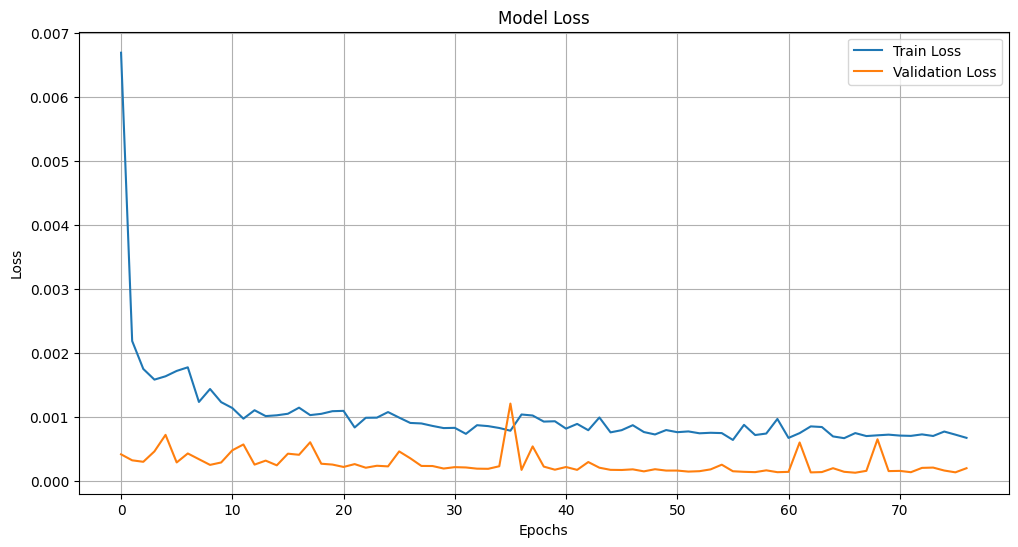

In [11]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_history.png')
plt.show()

In [12]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler_target.inverse_transform(train_predict)
test_predict = scaler_target.inverse_transform(test_predict)
y_train_actual = scaler_target.inverse_transform(y_train)
y_test_actual = scaler_target.inverse_transform(y_test)

# Calculate error metrics
train_rmse = math.sqrt(mean_squared_error(y_train_actual, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test_actual, test_predict))
print(f"\nTraining RMSE: {train_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Training RMSE: 75.22
Testing RMSE: 46.13


In [13]:
# Calculate MAPE (Mean Absolute Percentage Error)
train_mape = np.mean(np.abs((y_train_actual - train_predict) / y_train_actual)) * 100
test_mape = np.mean(np.abs((y_test_actual - test_predict) / y_test_actual)) * 100
print(f"Training MAPE: {train_mape:.2f}%")
print(f"Testing MAPE: {test_mape:.2f}%")

# Create timestamps for plotting
train_timestamps = train_data['Date'].values[time_steps:time_steps+len(train_predict)]
test_timestamps = test_data['Date'].values[time_steps:time_steps+len(test_predict)]

Training MAPE: 23.08%
Testing MAPE: 3.35%


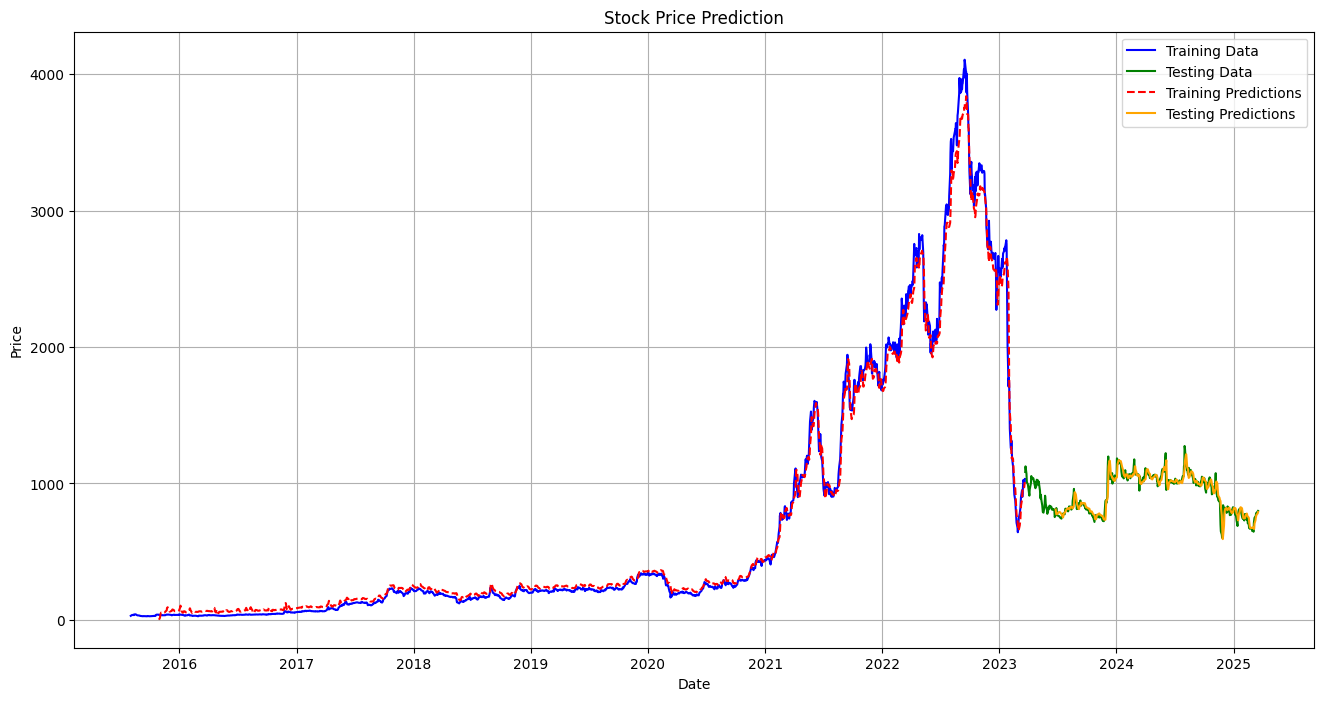

In [14]:
# Plot predictions vs actual
plt.figure(figsize=(16, 8))
plt.plot(train_data['Date'], train_data['Close'], 'b-', label='Training Data')
plt.plot(test_data['Date'], test_data['Close'], 'g-', label='Testing Data')
plt.plot(train_timestamps, train_predict, 'r--', label='Training Predictions')
plt.plot(test_timestamps, test_predict, 'orange', label='Testing Predictions')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.savefig('prediction_results.png')
plt.show()

In [15]:
# Function to predict future prices
def predict_future(model, last_sequence, scaler_features, scaler_target, n_future_days=30):
    """
    Predict future prices based on the last known sequence
    """
    future_predictions = []
    curr_sequence = last_sequence.copy()

    for _ in range(n_future_days):
        # Get prediction (scaled)
        scaled_pred = model.predict(curr_sequence.reshape(1, time_steps, len(features)))
        # Inverse transform to get actual price
        pred = scaler_target.inverse_transform(scaled_pred)[0][0]
        future_predictions.append(pred)

        # Update sequence for next prediction
        # Create new feature row based on our prediction
        # For simplicity, we'll use the last known ratios between Close and other features
        last_idx = -1
        ratios = {
            'Open': data['Open'].iloc[last_idx] / data['Close'].iloc[last_idx],
            'High': data['High'].iloc[last_idx] / data['Close'].iloc[last_idx],
            'Low': data['Low'].iloc[last_idx] / data['Close'].iloc[last_idx],
            'Volume': data['Volume'].iloc[last_idx]  # Keep last volume
        }

        # Create new feature row
        new_features = np.array([
            pred * ratios['Open'],
            pred * ratios['High'],
            pred * ratios['Low'],
            ratios['Volume']
        ])

        # Scale the new features
        new_features_scaled = scaler_features.transform(new_features.reshape(1, -1))

        # Update the sequence by removing the first element and adding the new one
        curr_sequence = np.vstack([curr_sequence[1:], new_features_scaled])

    return future_predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Forecast for the next 30 business days:
        Date  Forecasted_Close
0 2025-03-19        798.311829
1 2025-03-20        804.465576
2 2025-03-21        809.455139
3 2025-03-24        813.914673
4 2025-03-25        818.024353
5 2025-03-26        821.813171
6 2025-03-27        825.292603
7 2025-03-28        828.486450
8 2025-03-31        831.427246
9 2025-04-01        834.150940


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


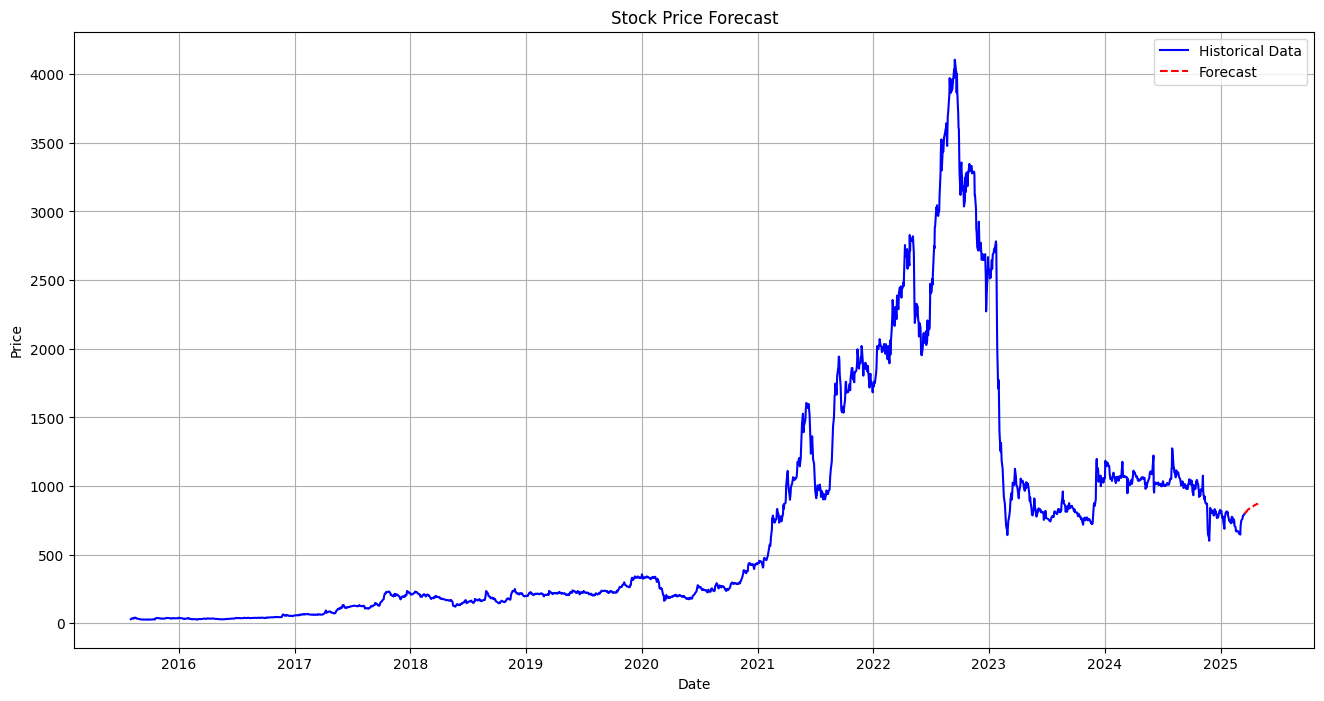


Forecast saved to 'price_forecast.csv'


In [16]:
# Get the last sequence from the test data
last_sequence = test_features_scaled[-time_steps:]

# Predict future prices
future_days = 30
future_predictions = predict_future(model, last_sequence, scaler_features, scaler_target, future_days)

# Create forecast dates (business days)
last_date = data['Date'].iloc[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days, freq='B')

# Create a forecast DataFrame
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted_Close': future_predictions
})

print("\nForecast for the next 30 business days:")
print(forecast_df.head(10))  # Show first 10 days

# Plot historical data and forecast
plt.figure(figsize=(16, 8))
plt.plot(data['Date'], data['Close'], 'b-', label='Historical Data')
plt.plot(forecast_df['Date'], forecast_df['Forecasted_Close'], 'r--', label='Forecast')
plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.savefig('forecast_results.png')
plt.show()

# Save the forecast to CSV
forecast_df.to_csv('price_forecast.csv', index=False)
print("\nForecast saved to 'price_forecast.csv'")